# Torch Batteries Example: Function Fitting with MLP

This notebook demonstrates how to use the `torch-batteries` library to train a Multi-Layer Perceptron (MLP) for function fitting. We'll use the event-driven training approach with the `@charge` decorator to define training, validation, testing, and prediction steps.

## Overview

We'll be fitting a polynomial function: `y = (x-1)(x-6)(x-7)` using a neural network with the Battery trainer class.

## 0. Installation

Install torch-batteries with necessary packages for this example:

In [1]:
%pip install torch-batteries[example]

/home/tosiek/Documents/IX_semestr/APP/torch-batteries/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


## 1. Setup and Dependencies

First, let's import the required libraries and check the versions of torch-batteries and PyTorch.

In [2]:
# Import torch-batteries and other dependencies
import torch

import torch_batteries

print(f"torch-batteries version: {torch_batteries.__version__}")
print(f"PyTorch version: {torch.__version__}")

torch-batteries version: 0.5.2
PyTorch version: 2.9.1+cu128


## 2. Data Preparation

We'll create a synthetic dataset by sampling from the polynomial function `y = (x-1)(x-6)(x-7)` and split it into training, validation, and test sets.

In [3]:
# Prepare data loaders
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

x = np.linspace(0, 10, 300).reshape(-1, 1).astype(np.float32)
y = ((x - 1) * (x - 6) * (x - 7)).astype(np.float32)

x_tensor = torch.from_numpy(x)
y_tensor = torch.from_numpy(y)

BATCH_SIZE = 16

pred_full_dataset = TensorDataset(x_tensor, y_tensor)
pred_full_loader = DataLoader(pred_full_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Split data into train/validation/test sets
x_train, x_rest, y_train, y_rest = train_test_split(
    x_tensor, y_tensor, test_size=0.3, random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_rest, y_rest, test_size=0.5, random_state=42
)

# Create datasets and data loaders
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training samples: 210
Validation samples: 45
Test samples: 45
Batch size: 16
Training batches: 14
Validation batches: 3
Test batches: 3


## 3. Model Definition and Training

Now we'll define our MLP model using the `@charge` decorator to specify what happens during training, validation, testing, and prediction steps. This event-driven approach makes the code more organized and follows a clear pattern.

### Key Features:
- **@charge(Event.TRAIN_STEP)**: Defines the forward pass and loss calculation for training
- **@charge(Event.VALIDATION_STEP)**: Defines validation logic
- **@charge(Event.TEST_STEP)**: Defines testing logic
- **@charge(Event.PREDICT_STEP)**: Defines prediction logic (forward pass only)

**Important**: Methods marked with the `@charge` decorator receive an `EventContext` parameter, which is a dictionary containing relevant information such as:
- `battery`: The Battery instance
- `model`: The model being trained/evaluated
- `batch`: The current batch data
- `batch_idx`: Index of the current batch
- `epoch`: Current epoch number
- `optimizer`: The optimizer being used (for training events)
- `loss`: Computed loss value (for AFTER_* events)
- `train_metrics`, `val_metrics`, `test_metrics`: Computed metrics for each phase

You can access these fields as needed in your step methods using `context["field_name"]`.

In [4]:
# Import torch-batteries components
from torch import nn
from torch.nn import functional as F  # noqa: N812

from torch_batteries import Battery, Event, charge
from torch_batteries.events import EventContext


# Define MLP model with charge decorators
class MLPModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.network(x)

    @charge(Event.TRAIN_STEP)
    def training_step(self, context: EventContext):
        """Define what happens in each training step."""
        batch = context["batch"]
        x, y = batch
        pred = self(x)
        return F.mse_loss(pred, y)

    @charge(Event.VALIDATION_STEP)
    def validation_step(self, context: EventContext):
        """Define what happens in each validation step."""
        batch = context["batch"]
        x, y = batch
        pred = self(x)

        return F.mse_loss(pred, y)

    @charge(Event.TEST_STEP)
    def test_step(self, context: EventContext):
        """Define what happens in each test step."""
        batch = context["batch"]
        x, y = batch
        pred = self(x)

        return F.mse_loss(pred, y)

    @charge(Event.PREDICT_STEP)
    def prediction_step(self, context: EventContext):
        """Define what happens during prediction."""
        batch = context["batch"]
        x = batch[0]
        return self(x)

### Using Custom Metrics

The `torch-batteries` library supports custom metrics tracking alongside loss in two ways:

#### Method 1: Pass metrics to Battery init (Automatic calculation)
Pass metric functions to `Battery(metrics={...})`. These are automatically calculated for each batch.

#### Method 2: Return metrics from step methods
Return `(loss, {'metric_name': value})` from your step methods for manual control.

#### Method 3: Combine both approaches
Metrics passed to `Battery` are calculated first, then merged with returned metrics (returned metrics override).

Now, let's see example with Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) as an additional metrics.

In [5]:
# Define metric functions (they take pred and target as arguments)
def mae_metric(pred, target):
    """Calculate Mean Absolute Error."""
    return F.l1_loss(pred, target)


def rmse_metric(pred, target):
    """Calculate Root Mean Squared Error."""
    return torch.sqrt(F.mse_loss(pred, target))


model = MLPModel(input_dim=1, hidden_dim=64, output_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

battery = Battery(
    model,
    optimizer=optimizer,
    metrics={
        "mae": mae_metric,
        "rmse": rmse_metric,  # Metrics calculated automatically!
    },
)

print("Starting training...")
train_results = battery.train(
    train_loader=train_loader, val_loader=val_loader, epochs=100
)

print("Training completed!")
print(f"Training Loss: {train_results['train_loss'][-1]:.6f}")
print(f"Training MAE: {train_results['train_metrics']['mae'][-1]:.6f}")
print(f"Training RMSE: {train_results['train_metrics']['rmse'][-1]:.6f}")
print(f"Validation Loss: {train_results['val_loss'][-1]:.6f}")
print(f"Validation MAE: {train_results['val_metrics']['mae'][-1]:.6f}")
print(f"Validation RMSE: {train_results['val_metrics']['rmse'][-1]:.6f}")

Starting training...


Epoch 100/100 [Validation]: 100%|██████████| 3/3 [00:00<00:00, 713.96it/s, Loss=5.3558, Mae=1.2467, Rmse=2.2076]

Training completed!
Training Loss: 10.732107
Training MAE: 2.088841
Training RMSE: 2.860400
Validation Loss: 5.355753
Validation MAE: 1.246696
Validation RMSE: 2.207646


## 4. Model Evaluation

Let's evaluate our trained model on the test set to see how well it generalizes to unseen data.

In [6]:
test_results = battery.test(test_loader)
print(f"Test Loss: {test_results['test_loss']:.6f}")
print(f"Test MAE: {test_results['test_metrics']['mae']:.6f}")
print(f"Test RMSE: {test_results['test_metrics']['rmse']:.6f}")

Epoch 1/1 [Test]: 100%|██████████| 3/3 [00:00<00:00, 914.46it/s, Loss=4.4829, Mae=1.2243, Rmse=2.0639]


Test Loss: 4.482935
Test MAE: 1.224327
Test RMSE: 2.063920


## 5. Results Visualization

Finally, let's visualize the training progress and see how well our model learned to approximate the target function.

Epoch 1/1 [Predict]: 100%|██████████| 19/19 [00:00<00:00, 3277.47it/s]


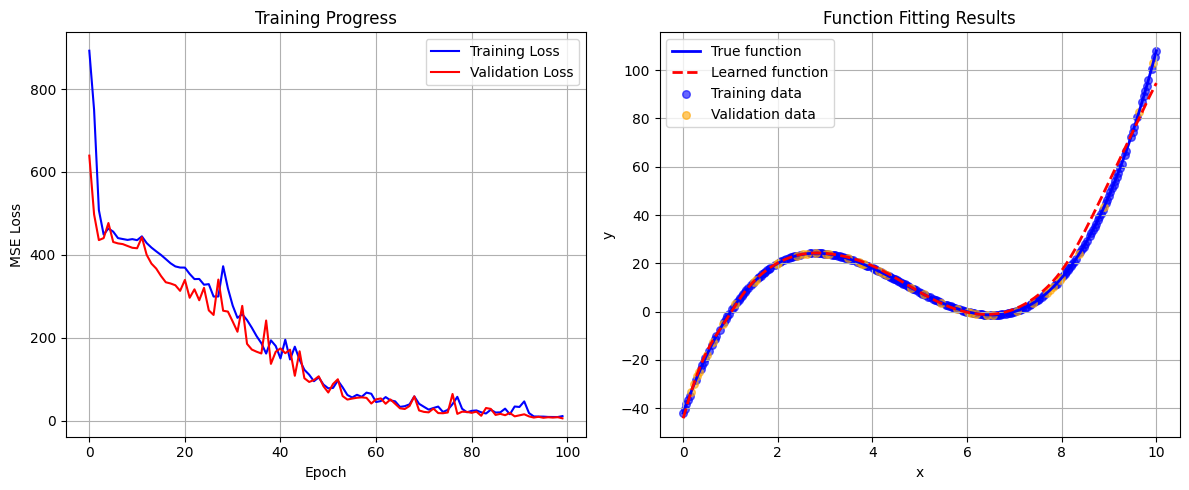

In [7]:
import matplotlib.pyplot as plt

# Plot training progress
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_results["train_loss"], "b-", label="Training Loss")
plt.plot(train_results["val_loss"], "r-", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Progress")
plt.legend()
plt.grid()

predictions = battery.predict(pred_full_loader)["predictions"]

# Concatenate predictions
y_pred = torch.cat(predictions, dim=0).cpu().numpy()
x_np = x_tensor.cpu().numpy()

# Plot actual vs predicted function
plt.subplot(1, 2, 2)
plt.plot(x_np, y, "b-", label="True function", linewidth=2)
plt.plot(x_np, y_pred, "r--", label="Learned function", linewidth=2)
plt.scatter(
    x_train.numpy(), y_train.numpy(), alpha=0.6, s=30, c="blue", label="Training data"
)
plt.scatter(
    x_val.numpy(), y_val.numpy(), alpha=0.6, s=30, c="orange", label="Validation data"
)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Function Fitting Results")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()